In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [88]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

In [89]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [90]:
datasize = 50
min_document_length = 512
max_document_length = None


index = -1
train_docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [91]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: rec.autos
while not exactly a service incident i have a similar experience recently when i bought a new truck i have picked out the vehicle i want and after a little haggle we agree on a price i write them a check for the down payment plus tax and license and told them i d be back that even to pick up the truck when i return i have to wait about an hour before the finance guy could get to me when i finally get in there everything go smoothly until he start add up the number he then discover that they have miscalculate the tax license by about 150 he then say he need another 150 from me i say we have already agree on a price and it be their problem i wasn t give them any more money the finance guy then brought in the manager on duty who proceed to give me a hard time i remind him that i be the customer and i didn t think i should be treat like that and that if he didn t back off he could forget the whole deal he make some smart remark so i told him where he could stick it snatch 

In [92]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[50, 50, 50, 50]


In [93]:
print(f"there are {len(train_docs)} docs")

there are 200 docs


### Initialize Vectorizer

In [94]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 8549


### Prepare Datatset

In [95]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

200 train_docs


### Word-Word Ratio

In [96]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T

probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
#     word_word_co[word] = np.log1p(pxy / (probability[word] * probability))
#     word_word_co[word] = pxy / (probability[word] * probability)
    word_word_co[word] = pxy / probability[word]

word_entropy = calculate_entropy(word_word_co.T, base=2)
word_word_co = (word_word_co.T * (word_entropy**-1)).T

word_word_co -= word_word_co.min().min()
word_word_co /= word_word_co.max().max()

word_word_co = word_word_co.fillna(0)
print(f"word_word_co has shape {word_word_co.shape}")


word_word_co has shape (8549, 8549)


In [97]:
word_word_co.head()

,000,0029,007,01,011,0119,013,0245,0320,04,...,zhigulis,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
000,0.400499,0.000000,0.400499,0.000000,0.000000,0.000000,0.0,0.000000,0.400499,0.133500,...,0.0,0.400499,0.0,0.0,0.0801,0.400499,0.0,0.0,0.0,0.0
0029,0.000000,0.566141,0.000000,0.188714,0.000000,0.000000,0.0,0.000000,0.000000,0.188714,...,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0
007,0.033530,0.000000,0.469423,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.469423,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0
01,0.000000,0.471671,0.000000,0.471671,0.000000,0.000000,0.0,0.471671,0.000000,0.314447,...,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0
011,0.000000,0.000000,0.000000,0.000000,0.790409,0.790409,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0


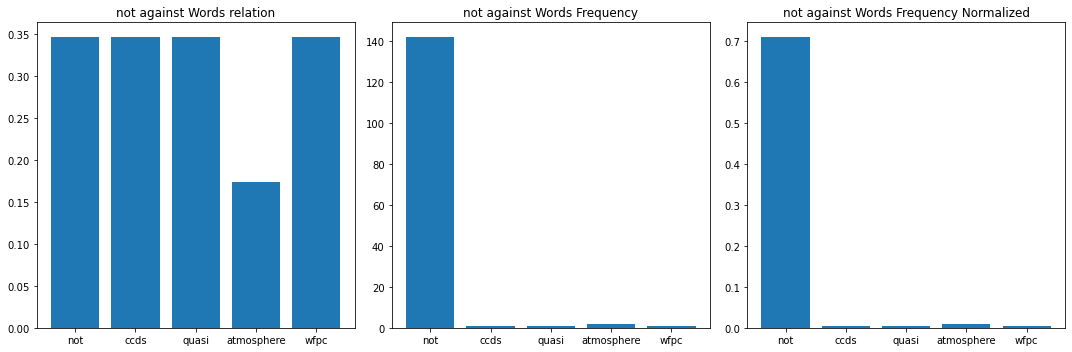

In [98]:
# word = "shuttle"
# words = ["the", "religion", "car", "and", "driver", "shuttle"]

words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]
word = words[0]

fig = plt.figure(figsize=(15,5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against Words relation")
ax11.bar(words, word_word_co.loc[word][words])

pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0)

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(words, pxy[words])

pxy /= total_num_of_documents

ax13.set_title(f"{word} against Words Frequency Normalized")
ax13.bar(words, pxy[words])

plt.show()

### Setup Doc Word Distr

In [109]:
number_of_iterations = 1
doc_word_distr = word_doc_frequency_norm.copy()

total_iterations = number_of_iterations * total_num_of_documents

with tqdm(total=total_iterations) as pbar:
    for n_iter in range(number_of_iterations):
        for doc_index in (range(total_num_of_documents)):
            
            words = word_doc_frequency_norm.columns[doc_word_distr.loc[doc_index] > 0]
            xv = (doc_word_distr.loc[doc_index][words] * word_word_co.loc[words].T).T
            doc_word_distr.loc[doc_index] = xv.mean(0)
            pbar.update(1)
            
        print(f"overall probability sum in docs {doc_word_distr.sum().sum()}")

overall probability sum in docs 2323.962127618931



In [110]:
doc_word_distr.head()

,000,0029,007,01,011,0119,013,0245,0320,04,...,zhigulis,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
0,0.000728,0.000487,0.001216,0.000649,0.000378,0.000378,0.001086,0.000802,0.000997,0.000658,...,0.001086,0.001216,0.000699,0.000948,0.000777,0.000986,0.000539,0.000493,0.000669,0.000493
1,0.001525,0.001120,0.002314,0.001509,0.000999,0.000999,0.001903,0.001807,0.001799,0.001414,...,0.001903,0.002314,0.001433,0.002045,0.001763,0.001687,0.001198,0.001267,0.001750,0.001024
2,0.001332,0.001347,0.002059,0.001460,0.000867,0.000867,0.001809,0.001617,0.001656,0.001340,...,0.001809,0.002059,0.001225,0.001724,0.001433,0.001761,0.001065,0.001034,0.001877,0.000852
3,0.000476,0.000346,0.000778,0.000460,0.000298,0.000298,0.000670,0.000537,0.000606,0.000453,...,0.000670,0.000778,0.000494,0.000663,0.000538,0.000625,0.000372,0.000383,0.000508,0.000310
4,0.001380,0.001275,0.002278,0.001709,0.001051,0.001051,0.001703,0.002401,0.001912,0.001619,...,0.001703,0.002278,0.001373,0.001732,0.001467,0.001627,0.001164,0.001227,0.002698,0.000976


In [111]:
doc_index = 3
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(10)

be      0.078475
the     0.034753
that    0.032511
he      0.026906
to      0.025785
it      0.022422
of      0.021300
have    0.016816
and     0.015695
in      0.014574
Name: 3, dtype: float64

In [112]:
doc_word_distr.loc[doc_index].sort_values(ascending=False).head(10)

felder           0.001125
betrayal         0.001125
prophecy         0.001125
explainations    0.001125
conclusively     0.001125
xian             0.001125
4019             0.001125
invalid          0.001125
crucifixion      0.001125
inspires         0.001125
Name: 3, dtype: float64

In [113]:
# word_word_co.loc["nucleus"].sort_values(ascending=False)

In [104]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: alt.atheism
first i want to start right out and say that i m a christian it make sense to be one have any of you read tony campollo s book liar lunatic or the real thing i might be a little off on the title but he writes the book anyway he be part of an effort to destroy christianity in the process he become a christian himself sound like you be say he be a part of some conspiracy just what organization do he belong to do it have a name the book say that jesus be either a liar or he be crazy a modern day koresh or he be actually who he say he be logic alert artificial trifercation the be many other possible explainations could have be that he never exist there have be some good point make in this group that be not impossible that jc be an amalgam of a number of different myth mithra come to mind some reason why he wouldn t be a liar be a follow who would die for a lie wouldn t people be able to tell if he be a liar people gather around him and kept do it many gather from hearing

### Define Latent partitions

In [140]:
reduction = None
# reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 2
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=True)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.sum(1), doc_word_distr.mean(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (200, 8549)


In [141]:
distr_params.head()

,000,0029,007,01,011,0119,013,0245,0320,04,...,zhigulis,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
0,0.000728,0.000487,0.001216,0.000649,0.000378,0.000378,0.001086,0.000802,0.000997,0.000658,...,0.001086,0.001216,0.000699,0.000948,0.000777,0.000986,0.000539,0.000493,0.000669,0.000493
1,0.001525,0.001120,0.002314,0.001509,0.000999,0.000999,0.001903,0.001807,0.001799,0.001414,...,0.001903,0.002314,0.001433,0.002045,0.001763,0.001687,0.001198,0.001267,0.001750,0.001024
2,0.001332,0.001347,0.002059,0.001460,0.000867,0.000867,0.001809,0.001617,0.001656,0.001340,...,0.001809,0.002059,0.001225,0.001724,0.001433,0.001761,0.001065,0.001034,0.001877,0.000852
3,0.000476,0.000346,0.000778,0.000460,0.000298,0.000298,0.000670,0.000537,0.000606,0.000453,...,0.000670,0.000778,0.000494,0.000663,0.000538,0.000625,0.000372,0.000383,0.000508,0.000310
4,0.001380,0.001275,0.002278,0.001709,0.001051,0.001051,0.001703,0.002401,0.001912,0.001619,...,0.001703,0.002278,0.001373,0.001732,0.001467,0.001627,0.001164,0.001227,0.002698,0.000976


### Using Kmeans MiniBatch

In [142]:
num_of_topics = 4

In [143]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)

In [144]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (200, 4), predicted_labels has shape (200,)


In [145]:
Counter(predicted_labels)

Counter({1: 47, 0: 60, 2: 38, 3: 55})

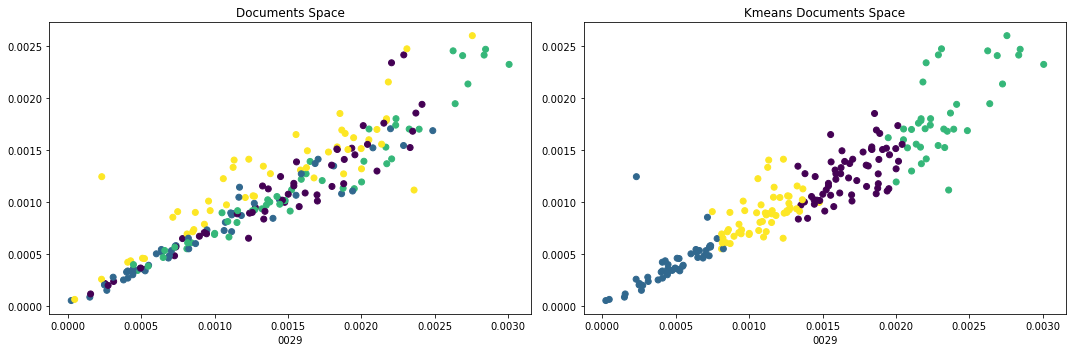

In [146]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Documents Space")
ax1.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
ax1.set_xlabel(columns[0])
ax1.set_xlabel(columns[1])

ax2.set_title("Kmeans Documents Space")
ax2.scatter(param_values[:, 0], param_values[:,1], c = predicted_labels)
ax2.set_xlabel(columns[0])
ax2.set_xlabel(columns[1])

plt.show()

In [147]:
def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [148]:
get_top(0)

Counter({'rec.autos': 21, 'sci.space': 16, 'alt.atheism': 14, 'talk.politics.mideast': 9})
88                0.002576
eventual          0.002576
cleaner           0.002576
pool              0.002576
void              0.002576
recommendation    0.002576
60hr14            0.002576
nokia             0.002576
alternatively     0.002576
crossposted       0.002576
dtype: float64


In [149]:
get_top(1)

Counter({'talk.politics.mideast': 24, 'rec.autos': 9, 'sci.space': 8, 'alt.atheism': 6})
chew             0.00075
obligate         0.00075
farther          0.00075
forbade          0.00075
tified           0.00075
shurik           0.00075
categorically    0.00075
anasha           0.00075
biting           0.00075
heaven           0.00075
dtype: float64


In [150]:
get_top(2)

Counter({'alt.atheism': 16, 'sci.space': 10, 'rec.autos': 8, 'talk.politics.mideast': 4})
directorate    0.003468
eskimo         0.003468
engels         0.003468
pacify         0.003468
entrance       0.003468
entreaty       0.003468
entryway       0.003468
overnight      0.003468
overheard      0.003468
overcharge     0.003468
dtype: float64


In [125]:
get_top(3)

Counter({'rec.autos': 1})
expires        0.013341
ct22           0.013341
keywords       0.013341
constantino    0.013341
cunixa         0.013341
cdac           0.013341
sender         0.013341
12789          0.013341
211457         0.013341
tobio          0.013341
dtype: float64


### LDA